In [606]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold

In [559]:
train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
train = train.drop('Id',axis=1) # remove ID variable, which is superfluous

# Feature Analysis

## Checking the target variable

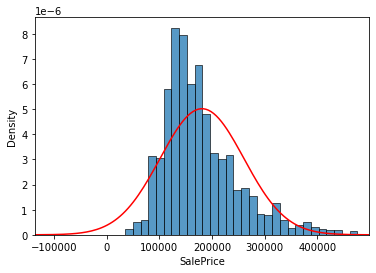

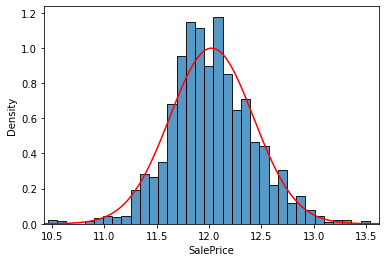

In [237]:
def hist_fit(y):
    fig = plt.figure()
    ax = sns.histplot(y,stat='density')
    mu,std = norm.fit(y)
    xmin,xmax = (mu-4*std,mu+4*std)
    x_pdf = np.linspace(xmin,xmax,130)
    y_pdf = stats.norm.pdf(x_pdf,mu,std)
    ax.plot(x_pdf,y_pdf,'r')
    plt.xlim(xmin,xmax)

hist_fit(y) # Right skewing
hist_fit(np.log(y)) # Much better fit!

## Checking the predictor variables
Next, I can check how all of the variables correlate with the sale price

<AxesSubplot:>

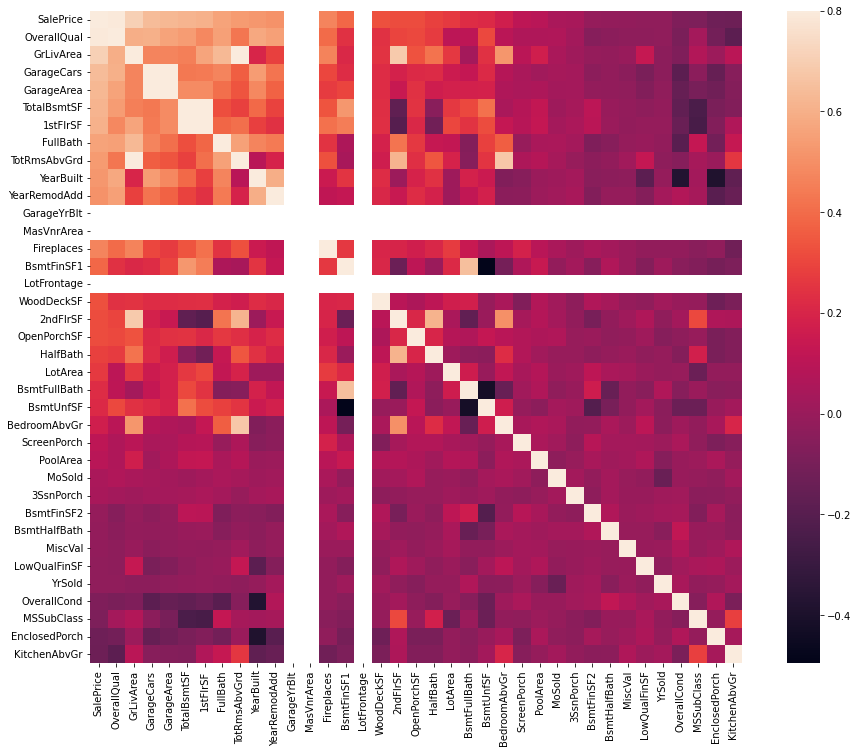

In [286]:
f,ax = plt.subplots(figsize=(16,12))
corr = train.corr()
#Get ranking of columns most correlated to the sale price
ranked_vars = corr.sort_values(by='SalePrice',ascending=False).index
#Correlate the ranking, transpose because corrcoeff needs rows to be variables
sns.heatmap(np.corrcoef(train[ranked_vars].values.T),vmax=0.8,square=True, 
            xticklabels=ranked_vars,yticklabels=ranked_vars)

In [410]:
train[ranked_vars[1:6]]

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF
0,7,1710,2,548,856
1,6,1262,2,460,1262
2,7,1786,2,608,920
3,7,1717,3,642,756
4,8,2198,3,836,1145
...,...,...,...,...,...
1455,6,1647,2,460,953
1456,6,2073,2,500,1542
1457,7,2340,1,252,1152
1458,5,1078,1,240,1078


From this the top components are:
1. Overall Quality
2. Above ground living area
3. Number of cars that can fit in the garage
4. Garage Area
5. Total number of square feet in the basement.

People really need space for their stuff, it seems

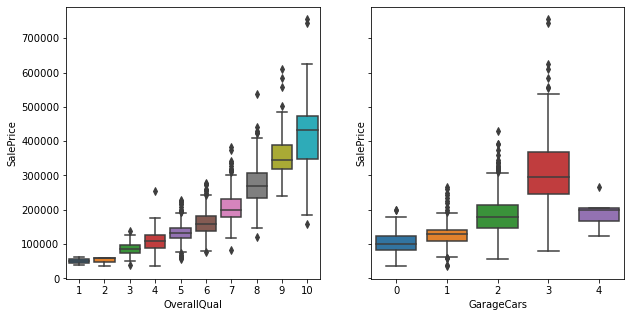

In [303]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
for i,name in enumerate(['OverallQual','GarageCars']):
    sns.boxplot(ax=axes[i],data=train,x=name,y='SalePrice')

People like quality, not surprisingly. They also like space for cars, but not more than 3

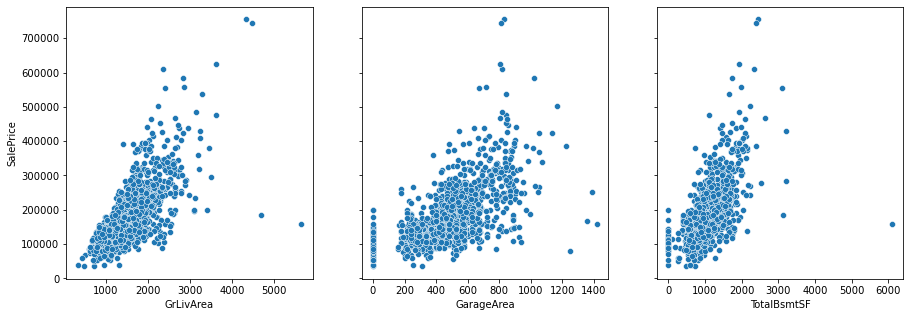

In [301]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i,name in enumerate(['GrLivArea','GarageArea','TotalBsmtSF']):
    sns.scatterplot(ax=axes[i], data=train,x=name,y='SalePrice')

Sale Price also seems to linearly increase with these three spaces

## Cleaning up predictor variables
The correlation map above shows giant white streaks, indicating that we have some columns with a lot of null entries

In [560]:
max_nan_prob = 0.25
train_nan_prob = pd.DataFrame((train.isna().sum()/len(train)).sort_values(ascending=False),columns = ['Prob'])
train = train.dropna(axis=1,thresh=len(train)*(1-max_nan_prob))
train_nan_prob[train_nan_prob>max_nan_prob].dropna()

,Prob
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603


We can drop these variables with more than 25% of their data missing. Pools and alleys aren't a factor for a house that often

In [394]:
train.isna().sum().sort_values(ascending=False).head(15)

LotFrontage     259
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
BsmtFinType2     38
BsmtExposure     38
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
MasVnrArea        8
MasVnrType        8
Electrical        1
KitchenAbvGr      0
dtype: int64

In [401]:
train.isna().any(axis=1).sum()/train.shape[0]

0.25068493150684934

# Modeling:
## Model 1 (the easier way): using the top features with Decision Tree Regression
Let's use the top 10 features discovered earlier, which conveniently do not have any remaining NaN Values, and they are all of the same type

In [569]:
X = train[ranked_vars[1:11]]
y = np.log(train[['SalePrice']]) #We take the log to achieve normal dist, as shown above
dtr = DecisionTreeRegressor()
dtr_score = np.sqrt(-cross_val_score(dtr,X,y,scoring='neg_mean_squared_error'))
print('Root mean square error:',dtr_score.mean())

Root mean square error: 0.2174548873637884


It isn't great, but its not a bad start! What if we tried random tree regression?

In [570]:
rfr = RandomForestRegressor()
rfr_score = np.sqrt(-cross_val_score(rfr,X,[i for i in y['SalePrice']],scoring='neg_mean_squared_error'))
print('Root mean square error:',rfr_score.mean())

Root mean square error: 0.16150534123714247


Even better. Maybe we can squeeze more juice out of this dataset by considering the other data with NaN in it.

## Method 2 (the harder way): filling NaN with imputation

In [402]:
train.dtypes[train.columns[train.isna().any()]]

LotFrontage     float64
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
dtype: object

The remaining data is of mixed type, but we can transform each using the simple imputer 'most_frequent' option

In [610]:
pipe = Pipeline([('simple',SimpleImputer(strategy='most_frequent')),
                ('ordinal',OrdinalEncoder())])
X = train.drop(['SalePrice'],axis=1)
X = pipe.fit_transform(X)

kf = KFold(n_splits=12, random_state=42, shuffle=True)
rfr_score = np.sqrt(-cross_val_score(rfr,X,[i for i in y['SalePrice']],
                                     scoring='neg_mean_squared_error',cv=kf))
print('Root mean square error:',rfr_score.mean())

Root mean square error: 0.14025266117066384


Its a little better, but its a little slow. Try xgboost instead

In [612]:
xgb = XGBRegressor()
xgb_score = np.sqrt(-cross_val_score(xgb,X,[i for i in y['SalePrice']],
                                     scoring='neg_mean_squared_error',cv=kf))
print('Root mean square error:',xgb_score.mean())

Root mean square error: 0.1391432557057639


Just as good, but much faster.

## Predicting test output

In [604]:
rfr.fit(X,[i for i in y['SalePrice']])

RandomForestRegressor()

In [605]:
test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")
test_id = test['Id']
test = test.drop('Id',axis=1) # remove ID variable, which is superfluous
X = test.dropna(axis=1,thresh=len(test)*(1-max_nan_prob))
X = pipe.fit_transform(X)
ypredict = np.exp(rfr.predict(X))
results = pd.concat([test_id,pd.DataFrame(ypredict,columns=['SalePrice'])],axis=1)
results

,Id,SalePrice
0,1461,124354.547307
1,1462,152154.496424
2,1463,182826.683317
3,1464,183094.221896
4,1465,199683.427728
...,...,...
1454,2915,90655.693326
1455,2916,92038.469101
1456,2917,150715.529824
1457,2918,114184.181844
